# Vegetation Change Detection

* **Products used:** 
ls8_sr

### Background 
Detecting regions of deforestation and afforestation in satellite imagery is complicated by the need to distinguish real land use changes from the natural changes introduced by climate variability. To determine regions that have undergone significant change, we can apply hypothesis testing techniques to stacks of remotely sensed satellite images to determine where change is statistically significant relative to the natural, background variability.

### Description
In this example, we measure the presence of vegetation from Landsat imagery and apply a hypothesis test to identify areas of significant change (along with the direction of the change).

The worked example takes users through the code required to do the following:
1. Load cloud-free Landsat 8 images for an area of interest (AOI).
1. Calculate indices that indicate vegetation, such as the normalised difference vegetation index (NDVI) and enhanced vegetation index (EVI).
2. Apply a statistical hypothesis test to find areas of significant change.
3. Visualise the statistically significant areas.

***

## Getting started
**To run this analysis**, run all the cells in the notebook, starting with the "Load packages" cell.

**After finishing the analysis**, return to the "Analysis parameters" cell, modify some values (e.g. choose a different location or time period to analyse) and re-run the analysis.
There are additional instructions on modifying the notebook at the end.

### Load packages
Load key Python packages and any supporting functions for the analysis.

In [1]:
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

import datacube
import datacube.utils.rio
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import xarray as xr
from datacube.utils.cog import write_cog

from deafrica_tools.datahandling import mostcommon_crs, load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import display_map, rgb

# Connect to AWS
from datacube.utils.aws import configure_s3_access
configure_s3_access(requester_pays=True)

### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [2]:
dc = datacube.Datacube(app="Change_detection")

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.
There is also a parameter to define how the data is split in time; the split yields two non-overlapping samples, which is a requirement of the hypothesis test we want to run (more detail below).
The parameters are:

* `latitude`: The latitude at the centre of your AOI (e.g. `0.02`).
* `longitude`: The longitude at the centre of your AOI (e.g. `35.425`).
* `buffer`: The number of degrees to load around the central latitude and longitude.
For reasonable loading times, set this as `0.1` or lower.
* `time`: The date range to analyse (e.g. `('2015-01-01', '2019-09-01')`).
For reasonable results, the range should span at least two years to prevent detecting seasonal changes.
* `time_baseline`: The date at which to split the total sample into two non-overlapping samples (e.g. `'2015-12-01'`).
For reasonable results, pick a date that is about halfway between the start and end dates specified in `time`.

**If running the notebook for the first time**, keep the default settings below.


In [3]:
# Define the area of interest
latitude = 36.8879 
longitude = -77.5581
buffer = 0.015 

# Combine central lat,lon with buffer to get area of interest
lat_range = (latitude-buffer, latitude+buffer)
lon_range = (longitude-buffer, longitude+buffer)

# Set the range of dates for the complete sample
time = ('2018-01-01', '2022-01-01')

# Set the date to separate the data into two samples for comparison
time_baseline = '2020-01-01'


## View the selected location
The next cell will display the selected area on an interactive map.
The red border represents the area of interest of the study.
Zoom in and out to get a better understanding of the area of interest.
Clicking anywhere on the map will reveal the latitude and longitude coordinates of the clicked point.

In [4]:
display_map(x=lon_range, y=lat_range)

## Load and view Landsat data

The first step in the analysis is to load Landsat data for the specified area of interest and time range. 

The code below will create a query dictionary for our region of interest, find the correct `crs` object for the area of interest, and then load the Landsat data using the `load_ard` function.
The function will also automatically mask out clouds from the dataset, allowing us to focus on pixels that contain useful data.
It will also exclude images where more than 70% of the pixels are masked, which is set using the `min_gooddata` parameter in the `load_ard` call.


In [5]:
#Create a query object
query = {
    'x': lon_range,
    'y': lat_range,
    'time': time,
    'measurements': ['red',
                     'green',
                     'blue',
                     'nir08'],
    'resolution': (-30, 30),
    'group_by': 'solar_day',
}

# find the right crs for the location
crs = 'epsg:6933'

# load cloud-masked fractional cover using load_ard
ds = load_ard(dc=dc,
              **query,
              products=['ls8_c2l2_sr'],
              align=(15, 15),
              output_crs=crs,
              min_gooddata=0.7
             )

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_c2l2_sr
Counting good quality pixels for each time step


Error opening source dataset: s3://usgs-landsat/collection02/level-2/standard/oli-tirs/2019/015/034/LC08_L2SP_015034_20191218_20200824_02_T1/LC08_L2SP_015034_20191218_20200824_02_T1_QA_PIXEL.TIF


RasterioIOError: '/vsis3/usgs-landsat/collection02/level-2/standard/oli-tirs/2019/015/034/LC08_L2SP_015034_20191218_20200824_02_T1/LC08_L2SP_015034_20191218_20200824_02_T1_QA_PIXEL.TIF' not recognized as a supported file format.

**Once the load is complete**, examine the data by printing it in the next cell.
The `Dimensions` argument revels the number of time steps in the data set, as well as the number of pixels in the x (longitude) and y (latitude) dimensions.

In [6]:
print(ds)

<xarray.Dataset>
Dimensions:      (time: 42, y: 103, x: 97)
Coordinates:
  * time         (time) datetime64[ns] 2018-03-18T15:46:23.523765 ... 2021-12...
  * y            (y) float64 4.396e+06 4.396e+06 ... 4.393e+06 4.393e+06
  * x            (x) float64 -7.485e+06 -7.485e+06 ... -7.482e+06 -7.482e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float32 0.1091 0.1092 0.1133 ... 0.03565 0.03111
    green        (time, y, x) float32 0.09576 0.08537 ... 0.03878 0.03435
    blue         (time, y, x) float32 0.06664 0.06865 ... 0.01882 0.01788
    nir08        (time, y, x) float32 1.483e+04 1.461e+04 ... 1.441e+04
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


### Plot example timesteps in true colour

Feel free to experiment with the values for the `initial_timestep` and `final_timestep` variables; re-run the cell to plot the images for the new timesteps.
The values for the timesteps can be `0` to one fewer than the number of time steps loaded in the data set.
The number of time steps is the same as the total number of observations listed as the output of the cell used to load the data.

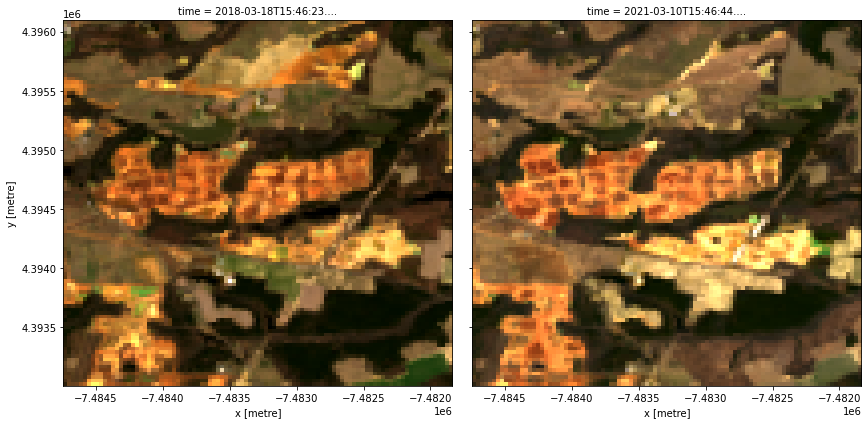

In [7]:
# Set the timesteps to visualise
initial_timestep = 0
final_timestep = 41

rgb(ds, index=[initial_timestep, final_timestep])

## Compute band indices
For this study, there are two indices that can be used as proxies for vegetation.

The first is the normalised difference vegetation index (NDVI).
This index uses the ratio of the red and near-infrared (NIR) bands to identify live green vegetation. 
The formula is:

$$
\begin{aligned}
\text{NDVI} = \frac{\text{NIR} - \text{Red}}{\text{NIR} + \text{Red}}.
\end{aligned}
$$

The second is the enhanced vegetation index (EVI).
This index uses the red, near-infrared (NIR) and blue bands to identify vegetation; it is particularly sensitive to high biomass regions.
The formula is:

$$
\begin{aligned}
\text{EVI} = \frac{2.5 \times (\text{NIR} - \text{Red})}{\text{NIR} + 6 \times \text{Red} - 7.5 \times \text{Blue} + 1}.
\end{aligned}
$$

When interpreting these indices, high values indicate vegetation.

### Using an index in this notebook

The cell below calculates the chosen index, adds it to the dataset, then creates a new object `ds_index` that only contains the calculated index, allowing it to be used throughout the rest of the notebook. 

To use `NDVI`, run the following code in the cell below:
```
ds = calculate_indices(ds, 'NDVI', satellite_mission='ls')
ds_index = ds.NDVI
```

To use `EVI`, run the following code in the cell below:
```
ds = calculate_indices(ds, 'EVI', satellite_mission='ls')
ds_index = ds.EVI
```

In [8]:
# Calculate NDVI and add it to the loaded dataset

# ds = calculate_indices(ds, 'NDVI', satellite_mission='ls')
# ds_index = ds.NDVI

ds = calculate_indices(ds, 'EVI', satellite_mission='ls')
ds_index = ds.EVI

### Visualising the index

The plots below show the chosen index values for the two selected timesteps used to make the true-colour images above.
Use the plots to visually confirm whether the chosen index is a suitable for change detection.

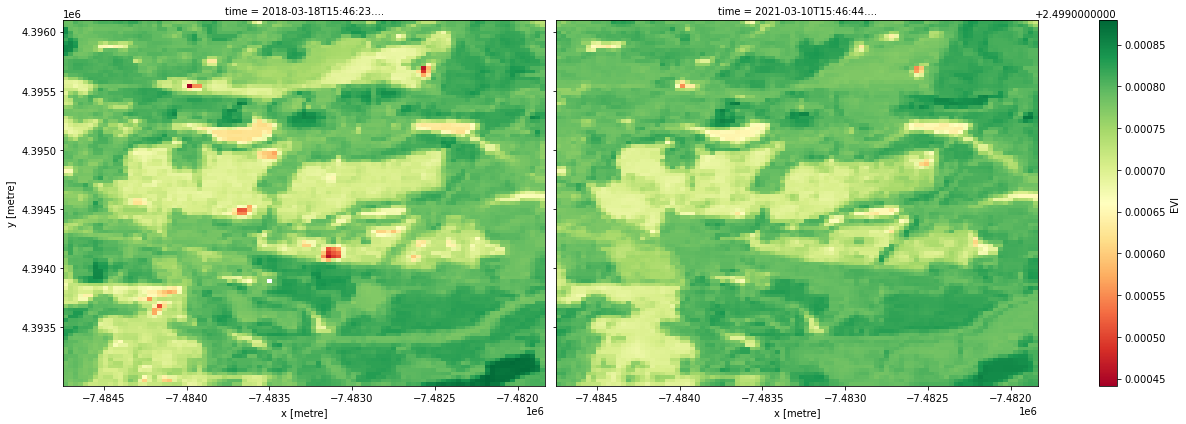

In [9]:
# Plot the NDVI values for pixels classified as vegetation for the two dates.
ds_index.isel(time=[initial_timestep, final_timestep]).plot.imshow(
    'x', 'y', col='time', cmap='RdYlGn', figsize=(18, 6)
)

plt.show()

## Perform hypothesis test
While it is possible to visually detect change between the two timesteps, it is important to consider how to rigorously check for both positive change in vegetation (afforestation) and negative change in vegetation (deforestation).

This can be done through hypothesis testing.
In this case, 

$$
\begin{aligned}
\text{null hypothesis } (H_0) &: \text{no change occurred,} \\
\text{alternative hypothesis } (H_1) &: \text{some change occurred.}
\end{aligned}
$$

The hypothesis test will indicate where there is evidence for rejecting the null hypothesis.
From this, we may identify areas of signficant change, according to a given significance level (covered in more detail below).

### Make samples

To perform the test, the total sample will be split in two: a `baseline` sample and a `postbaseline` sample, which respectively contain the data before and after the `time_baseline` date.
Then, we can test for a difference in the average vegetation index (either `NDVI` or `EVI`) between the samples for each pixel in the sample.
In this step, we also make mean composites for both samples, which will be useful later on for visualising the comparison.

The samples are made by filtering the index based on whether it was observed before or after the `time_baseline` date.
The number of observations in each sample will be printed.
If one sample is much larger than the other, consider changing the `time_baseline` parameter in the "Analysis parameters" cell, and then re-run this cell.
Coordinates are recorded for later use.

In [10]:
# Make samples
baseline_sample = ds_index.sel(time=ds['time'] <= np.datetime64(time_baseline))
baseline_composite = ds.sel(time=ds['time'] <= np.datetime64(time_baseline)).mean(dim=['time'])
print(f"Number of observations in baseline sample: {len(baseline_sample.time)}")

postbaseline_sample = ds_index.sel(time=ds['time'] > np.datetime64(time_baseline))
postbaseline_composite = ds.sel(time=ds['time'] > np.datetime64(time_baseline)).mean(dim=['time'])
print(f"Number of observations in postbaseline sample: {len(postbaseline_sample.time)}")

# Record coodrinates for reconstructing xarray objects
sample_lat_coords = ds.coords['y']
sample_lon_coords = ds.coords['x']


Number of observations in baseline sample: 21
Number of observations in postbaseline sample: 21


### Test for change
To look for evidence that the average index value has changed between the two samples (either positively or negatively), we use Welch's t-test.
This is used to test the hypothesis that two populations have equal averages.
In this case, the populations are the area of interest before and after the `time_baseline` date, and the average being tested is the average index value.
Welch's *t*-test is used (as opposed to Student's *t*-test) because the two samples in the study may not necessarily have equal variances. 

The test is run using the Scipy package's statistcs library, which provides the `ttest_ind` function for running *t*-tests. 
Setting `equal_var=False` means that the function will run Welch's *t*-test.
The function returns the *t*-statistic and *p*-value for each pixel after testing the difference in the average index value.
These are stored as `t_stat` and `p_val` inside the `t_test` dataset for use in the next section.

In [11]:
# Perform the t-test on the postbaseline and baseline samples
tstat, p_tstat = stats.ttest_ind(
    postbaseline_sample.values,
    baseline_sample.values,
    equal_var=False,
    nan_policy='omit',
)

# Convert results to an xarray for further analysis
t_test = xr.Dataset(
    {'t_stat': (['y', 'x'], tstat),
     'p_val': (['y', 'x'], p_tstat)},
    coords={
     'x': (['x'], sample_lon_coords.values),
     'y': (['y'], sample_lat_coords.values)
    }, attrs={'crs': ds.geobox.crs})

print(t_test)


<xarray.Dataset>
Dimensions:  (y: 103, x: 97)
Coordinates:
  * x        (x) float64 -7.485e+06 -7.485e+06 ... -7.482e+06 -7.482e+06
  * y        (y) float64 4.396e+06 4.396e+06 4.396e+06 ... 4.393e+06 4.393e+06
Data variables:
    t_stat   (y, x) float64 -1.19 -1.644 -1.409 -0.794 ... -1.168 -1.237 -1.291
    p_val    (y, x) float64 0.2436 0.1112 0.1692 0.433 ... 0.25 0.224 0.2049
Attributes:
    crs:      PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 Global",GEOGCS["WGS 84",DA...


## Visualise change
From the test, we're interested in two conditions: whether the change is significant (rejection of the null hypothesis) and whether the change was positive (afforestation) or negative (deforestation).

The null hypothesis can be rejected if the $p$-value (`p_val`) is less than the chosen significance level, which is set as `sig_level = 0.01` for this analysis.
If the null hypothesis is rejected, the pixel will be classified as having undergone significant change.

The direction of the change can be inferred from the difference in the average index of each sample, which is calculated as $\text{diff mean} = \text{mean(post baseline)} - \text{mean(baseline)}.$

This means that
- if the average index value for a given pixel is **higher** in the `post baseline` sample compared to the `baseline` sample, then `diff_mean` for that pixel will be **positive**.
- if the average index value for a given pixel is **lower** in the `post baseline` sample compared to the `baseline` sample, then `diff_mean` for that pixel will be **negative**.

Run the cell below to plot the baseline and post-baseline composites, the differences that were marked as signficant, and the mask showing areas of significant deforestation. 

>**Note:** For the plot showing areas of significant difference between the samples, positive change is shown in blue and negative change is shown in red.

In [12]:
# Set the significance level
sig_level = 0.01

# Identify any difference in the mean
diff_mean = postbaseline_sample.mean(
    dim=['time']) - baseline_sample.mean(dim=['time'])
diff_mean.name = f"{baseline_sample.name} Difference"

# Identify any difference in the mean classified as significant
sig_diff_mean = postbaseline_sample.mean(dim=['time']).where(
    t_test.p_val < sig_level) - baseline_sample.mean(dim=['time']).where(t_test.p_val < sig_level)
sig_diff_mean.name = f"{baseline_sample.name} Difference"

# Determine areas with significant deforestation (negative difference)
sig_deforestation = sig_diff_mean < 0
sig_deforestation.name = "Deforestation"

# Determine areas with significant afforestations (positive difference)
sig_afforestation = sig_diff_mean > 0
sig_afforestation.name = "Afforestation"

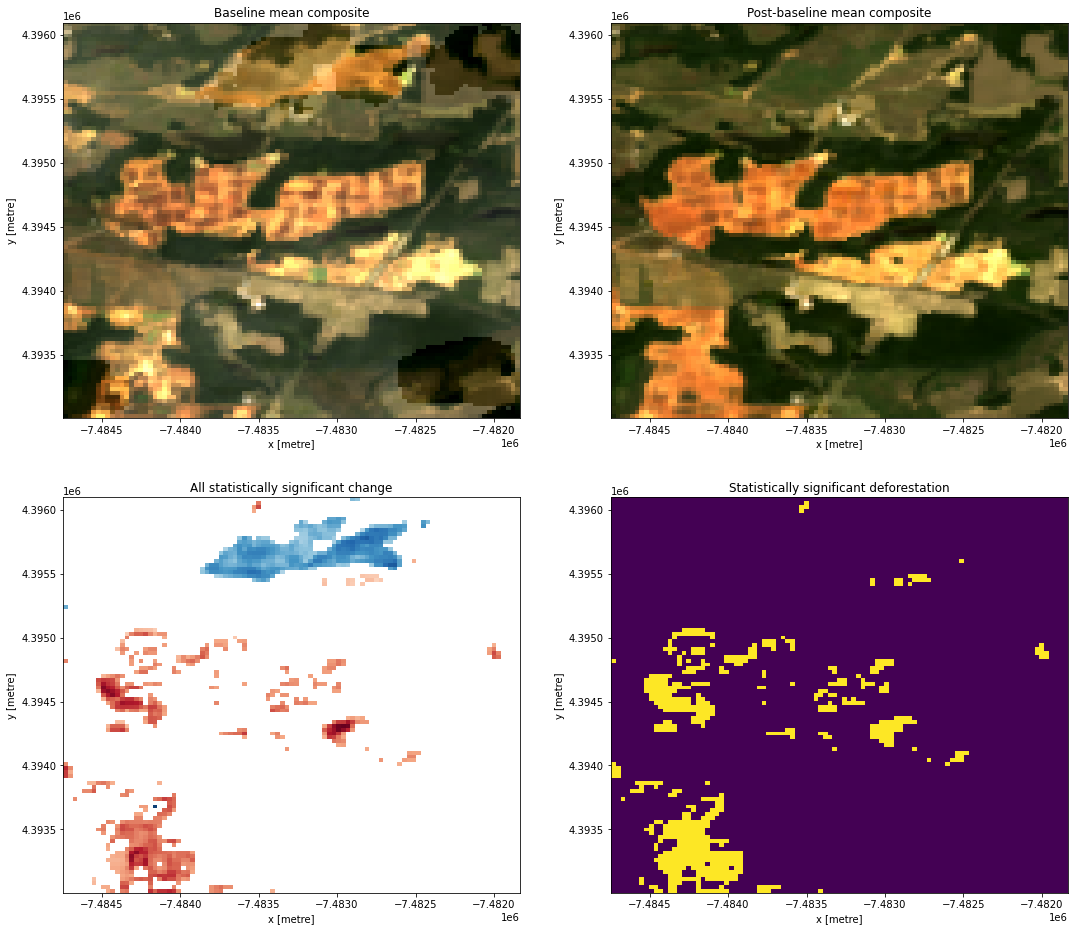

In [13]:
# Construct the comparison plot
fig, ax = plt.subplots(2, 2, figsize=(18, 16))
baseline_composite[['red', 'green', 'blue']].to_array().plot.imshow(ax=ax[0,0], robust=True)
postbaseline_composite[['red', 'green', 'blue']].to_array().plot.imshow(ax=ax[0,1], robust=True)
sig_diff_mean.plot(cmap='RdBu', ax=ax[1,0], add_colorbar=False)
sig_deforestation.plot(ax=ax[1,1], add_colorbar=False)
ax[0,0].set_title('Baseline mean composite')
ax[0,1].set_title('Post-baseline mean composite')
ax[1,0].set_title('All statistically significant change')
ax[1,1].set_title('Statistically significant deforestation')
plt.show()


## Calculate percentage change

In addition to producing visualisations of the change, we can also estimate the number and proportion of pixels that have undergone statistically significant change.

In [14]:
total_pixels = postbaseline_sample.mean(dim=['time']).count(dim=['x', 'y']).values
total_sig_change = sig_diff_mean.count(dim=['x', 'y']).values
total_deforestation = sig_deforestation.where(sig_deforestation==True).count(dim=['x', 'y']).values

percentage_sig_change = (total_sig_change/total_pixels)*100
percentage_deforestation = (total_deforestation/total_pixels)*100

print(f"{percentage_sig_change:.2f}% of pixels that likely underwent significant change in any direction")
print(f"{percentage_deforestation:.2f}% of pixels that likely underwent deforestation")

10.49% of pixels that likely underwent significant change in any direction
6.43% of pixels that likely underwent deforestation


## Drawing conclusions
Here are some questions to think about:
- What has happened in the forest over the time covered by the dataset?
- Were there any statistically significant changes that the test found that you didn't see in the true-colour images? 
- What kind of activities/events might explain the significant changes?
- What kind of activities/events might explain non-significant changes?
- What other information might you need to draw conclusions about the cause of the statistically significant changes?

## Next steps

When you are done, return to the "Analysis parameters" section, modify some values (e.g. `latitude`, `longitude`, `time` or `time_baseline`) and re-run the analysis.
You can use the interactive map in the "View the selected location" section to find new central latitude and longitude values by panning and zooming, and then clicking on the area you wish to extract location values for.
You can also use Google maps to search for a location you know, then return the latitude and longitude values by clicking the map.

You could also return to the "Compute band indices" section and change which index you use.

---

## Additional information

**License:** The code in this notebook is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Compatible datacube version:**

In [16]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [17]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2022-08-08'